In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import time
from typing import Tuple, Type

import haiku as hk
import jax
import jax.numpy as jnp
import jraph
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import optax

# Numpyro
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi

# Local imports
import loss
import dataset_1dgp
import plotting
import model

print(f"JAX version: {jax.__version__}")
print(f"Numpyro version: {numpyro.__version__}")

/Users/salmanfaris/miniforge3/envs/prior-vgae/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


JAX version: 0.3.13
Numpyro version: 0.9.2


In [2]:
FIG_PATH = Path('./figures/1DGP_figures')
FIG_PATH.mkdir(exist_ok=True)

DATASET_PATH = Path('./dataset.nosync')
DATASET_PATH.mkdir(exist_ok=True)

In [3]:
RNG_SEED = 44
RNG_KEY = jax.random.PRNGKey(RNG_SEED)

In [4]:
from dataclasses import dataclass
from typing import Dict, Optional, Callable

LossFun = Callable[[jax.numpy.ndarray, jax.numpy.ndarray], jnp.float32]

@dataclass
class GP1DArgs:
  kernel: Callable = dataset_1dgp.exp_sq_kernel
  num_locations: int = 400
  
@dataclass
class Args:  
  # Training params
  loss_fn: LossFun = loss.compute_mse_loss
  epochs: int = 500_000
  eval_frequency: int = 1000
  learning_rate: float = 1e-3
  beta: float = 1e-2  # beta-VAE
  
  # Model params
  hidden_gnn_dim: int = 3
  hidden_fc_dim: int = 50
  latent_dim: int = 30
  output_dim: int = 1
  act_fn: Callable = jax.nn.elu

GP1D_ARGS = GP1DArgs()
ARGS = Args()

In [5]:
model_name = (
    f'PriorVGAE_1DGP_lr{ARGS.learning_rate}_epochs{ARGS.epochs}_'
    f'beta{ARGS.beta}_gnn{ARGS.hidden_gnn_dim}_fc{ARGS.hidden_fc_dim}_z{ARGS.latent_dim}_'
    f'numLocations{GP1D_ARGS.num_locations}'
)

model_params_title = (
    '('
    f'epochs = {plotting.convert_to_string_int(ARGS.epochs)}, '
    f'lr = {ARGS.learning_rate}, '
    f'act_fn = {jax.nn.elu.__name__}, '
    rf'$\beta = {ARGS.beta}$, '
    f'\ngnn_dim = {ARGS.hidden_gnn_dim},  fc_dim = {ARGS.hidden_fc_dim},  z_dim = {ARGS.latent_dim}'
    f'\n num_loc = {GP1D_ARGS.num_locations}'
    ')'
)

print(model_name)

PriorVGAE_1DGP_lr0.001_epochs500000_beta0.01_gnn3_fc50_z30_numLocations400


# Dataset: GP priors to be encoded

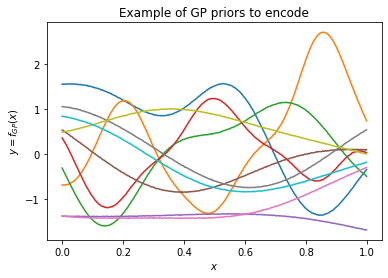

In [6]:
# GP priors to encode
X = jnp.arange(0, 1, 1/GP1D_ARGS.num_locations)

num_to_plot = 10
gp_draws = dataset_1dgp.generate_gp_batch(RNG_KEY, 
                                          X, 
                                          batch_size=num_to_plot,
                                          kernel=GP1D_ARGS.kernel)

plotting.plot_gp_draws(
    X, gp_draws,
    num_draws_to_plot=num_to_plot,
    title='Example of GP priors to encode', 
    x_label='$x$', 
    y_label='$y=f_{GP}(x)$',
)

# Building the model

In [7]:
data_filepath = DATASET_PATH / f'1DGP_numLoc{GP1D_ARGS.num_locations}_1M_train_data.npy'

OVERRIDE_SAVE = False

# Initial RNG_KEY seed is 44.
RNG_KEY, data_rng = jax.random.split(RNG_KEY)
if data_filepath.exists() and not OVERRIDE_SAVE:
    print(f"Loading dataset from {data_filepath}")
    data = np.load(data_filepath)
else:
    num_samples = 1_000_000
    data = dataset_1dgp.generate_gp_batch(data_rng, X, 
                                          batch_size=num_samples, 
                                          kernel=GP1D_ARGS.kernel)
    print(f"Saving dataset to {data_filepath}")
    np.save(data_filepath, np.asarray(data))

Loading dataset from dataset.nosync/1DGP_numLoc400_1M_train_data.npy


In [8]:
# Remove NaNs from dataset
data = data[~np.isnan(data).any(axis=1), :]

train_size_limit = 700_000
val_size = 11_000  # + 1000 for the final epoch evaluation and batching

# train_data = data[:train_size_limit]
train_data = data[:]
val_data = data[train_size_limit:train_size_limit+val_size]

In [9]:
BASE_GRAPH = dataset_1dgp.create_1dgp_graph(GP1D_ARGS.num_locations)

graph_train_data = [BASE_GRAPH._replace(nodes=nodes.reshape(-1, 1)) for nodes in train_data]
graph_val_data = [BASE_GRAPH._replace(nodes=nodes.reshape(-1, 1)) for nodes in val_data]

# Training time

In [10]:
def training_loop(rng_key, model, optimizer, epochs):
  loss_rng, train_rng = jax.random.split(rng_key)
  
  # Initialize net with an arbitrary graph
  init_graph = graph_train_data[0]
  params = model.init(rng_key, init_graph)
  opt_state = optimizer.init(params)
  
  @jax.jit
  def loss_fn(
      params: hk.Params, 
      rng_key: jnp.ndarray,
      graph: jraph.GraphsTuple,
  ) -> jnp.ndarray:
    """Computes VGAE loss."""
    log_likelihood_loss_fn = ARGS.loss_fn
    
    outputs: model.VGAEOutput = model.apply(params, rng_key, graph)
    log_likelihood = -log_likelihood_loss_fn(outputs.output.nodes, graph.nodes)
    kld = jnp.mean(loss.compute_kl_gaussian(outputs.mean, outputs.log_std), axis=-1)
    elbo = (1.0/ARGS.beta)*log_likelihood - kld
    
    return -elbo, kld
    
  @jax.jit
  def update(
      params: hk.Params,
      rng_key: jnp.ndarray,
      opt_state: optax.OptState,
      graph: jraph.GraphsTuple,
  ):
    """Updates the parameters of the network."""
    grads, _ = jax.grad(loss_fn, has_aux=True)(params, rng_key, graph)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state


  train_losses = []
  val_losses = []
  train_klds = []
  val_klds = []

  train_size = len(graph_train_data)
  val_size = len(graph_val_data)

  eval_counter: int = 0

  training_start_time = time.time()
  print('using: ', ARGS.loss_fn)
  for epoch in range(epochs):
    update_rng = jax.random.fold_in(train_rng, epoch)

    train_graph_batch = graph_train_data[epoch % train_size]
    params, opt_state = update(params, update_rng, opt_state, train_graph_batch)
      
    if epoch % ARGS.eval_frequency == 0 or epoch == (ARGS.epochs - 1):
      evaluate_rng = jax.random.fold_in(update_rng, epoch)
      train_loss_rng, eval_loss_rng = jax.random.split(evaluate_rng)
      
      train_loss, train_kld = loss_fn(params, train_loss_rng, train_graph_batch)
      
      val_graph_batch = graph_val_data[eval_counter]
      val_loss, val_kld = loss_fn(params, eval_loss_rng, val_graph_batch)
      
      print(f'{time.strftime("%H:%M:%S", time.localtime())} STEP: {epoch}; '
            f'Train loss: {train_loss:.3f}; Validation loss: {val_loss:.3f}; '
            # f'Train kld: {train_kld:.3f}; Validation kld: {val_kld:.3f}'
      )
        
      train_losses.append(train_loss.item())
      val_losses.append(val_loss.item())
      train_klds.append(train_kld.item())
      val_klds.append(val_kld.item())
      
      eval_counter += 1

  training_end_time = time.time() - training_start_time
  print(f'Training took: ({training_end_time:.3f} secs; equivalently {training_end_time/60:.3f} mins)')
  
  # Loss plots
  fig, ax = plt.subplots(figsize=(11, 7))

  xs = np.arange(len(train_losses))*ARGS.eval_frequency
  ax.plot(xs, train_losses, label='train_loss')
  ax.plot(xs, val_losses, label='val_loss')
  ax.set_title('Loss (all epochs)')

  ax.set_ylabel('Loss')
  ax.set_xlabel('Epochs')
  ax.legend()

  fig.suptitle(f'Training loss', fontsize='xx-large')

  plt.tight_layout()
  plt.show()
  
  return params

## Model

In [11]:
# optimizer = optax.adam(ARGS.learning_rate)

scheduler = optax.exponential_decay(
    init_value=ARGS.learning_rate,
    transition_steps=2000,
    decay_rate=0.99,
)

# Combining gradient transforms using `optax.chain`
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    optax.scale_by_adam(),  # Use the updates from adam.
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

using:  <function compute_mse_loss at 0x146df2040>
13:56:21 STEP: 0; Train loss: 93.559; Validation loss: 171.125; 
13:56:22 STEP: 1000; Train loss: 45.724; Validation loss: 31.190; 
13:56:22 STEP: 2000; Train loss: 22.950; Validation loss: 32.503; 
13:56:23 STEP: 3000; Train loss: 57.204; Validation loss: 27.563; 
13:56:23 STEP: 4000; Train loss: 73.065; Validation loss: 21.632; 
13:56:23 STEP: 5000; Train loss: 83.383; Validation loss: 50.389; 
13:56:24 STEP: 6000; Train loss: 25.399; Validation loss: 105.853; 
13:56:24 STEP: 7000; Train loss: 13.903; Validation loss: 42.462; 
13:56:25 STEP: 8000; Train loss: 82.699; Validation loss: 46.009; 
13:56:25 STEP: 9000; Train loss: 10.725; Validation loss: 42.980; 
13:56:26 STEP: 10000; Train loss: 18.512; Validation loss: 57.119; 
13:56:26 STEP: 11000; Train loss: 42.408; Validation loss: 10.670; 
13:56:27 STEP: 12000; Train loss: 11.972; Validation loss: 19.127; 
13:56:27 STEP: 13000; Train loss: 13.631; Validation loss: 27.511; 
13:56:28

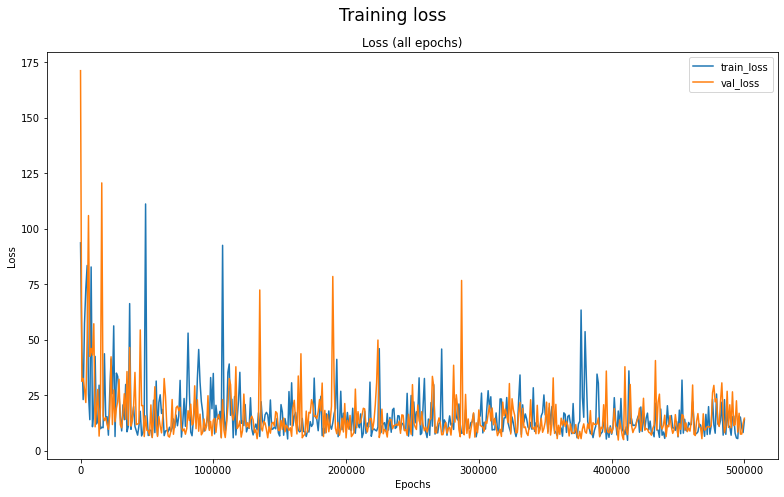

using:  <function compute_mse_loss at 0x146df2040>
14:00:42 STEP: 0; Train loss: 92.612; Validation loss: 203.325; 
14:00:42 STEP: 1000; Train loss: 24.136; Validation loss: 35.511; 
14:00:43 STEP: 2000; Train loss: 24.926; Validation loss: 24.466; 
14:00:43 STEP: 3000; Train loss: 32.480; Validation loss: 26.844; 
14:00:44 STEP: 4000; Train loss: 46.140; Validation loss: 12.901; 
14:00:44 STEP: 5000; Train loss: 109.161; Validation loss: 18.818; 
14:00:45 STEP: 6000; Train loss: 11.455; Validation loss: 100.947; 
14:00:46 STEP: 7000; Train loss: 17.939; Validation loss: 35.391; 
14:00:46 STEP: 8000; Train loss: 34.678; Validation loss: 7.532; 
14:00:47 STEP: 9000; Train loss: 21.746; Validation loss: 15.755; 
14:00:47 STEP: 10000; Train loss: 7.750; Validation loss: 60.975; 
14:00:48 STEP: 11000; Train loss: 16.262; Validation loss: 36.480; 
14:00:48 STEP: 12000; Train loss: 47.228; Validation loss: 15.880; 
14:00:49 STEP: 13000; Train loss: 11.833; Validation loss: 7.093; 
14:00:49 S

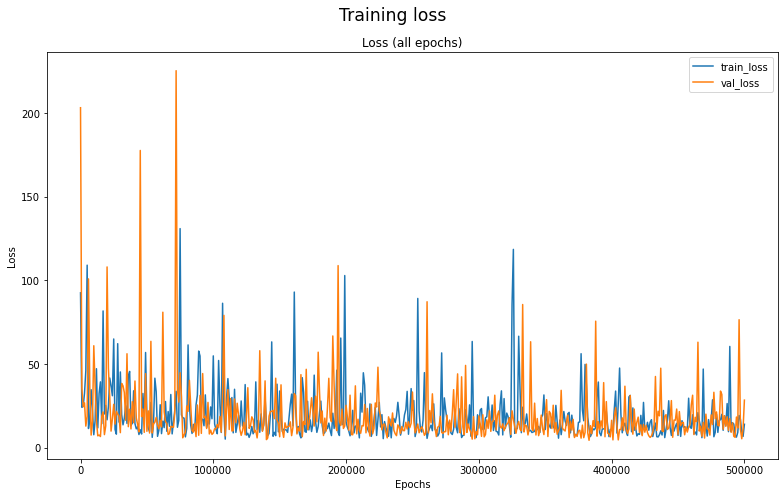

using:  <function compute_mse_loss at 0x146df2040>
14:05:12 STEP: 0; Train loss: 77.748; Validation loss: 230.567; 
14:05:13 STEP: 1000; Train loss: 26.814; Validation loss: 17.908; 
14:05:13 STEP: 2000; Train loss: 13.992; Validation loss: 46.473; 
14:05:14 STEP: 3000; Train loss: 29.328; Validation loss: 37.759; 
14:05:15 STEP: 4000; Train loss: 118.858; Validation loss: 16.952; 
14:05:15 STEP: 5000; Train loss: 82.029; Validation loss: 42.376; 
14:05:16 STEP: 6000; Train loss: 8.960; Validation loss: 96.645; 
14:05:16 STEP: 7000; Train loss: 18.855; Validation loss: 46.368; 
14:05:17 STEP: 8000; Train loss: 40.315; Validation loss: 17.341; 
14:05:17 STEP: 9000; Train loss: 41.869; Validation loss: 31.140; 
14:05:18 STEP: 10000; Train loss: 60.029; Validation loss: 157.448; 
14:05:19 STEP: 11000; Train loss: 12.739; Validation loss: 35.001; 
14:05:19 STEP: 12000; Train loss: 45.343; Validation loss: 40.933; 
14:05:20 STEP: 13000; Train loss: 26.007; Validation loss: 9.960; 
14:05:20 

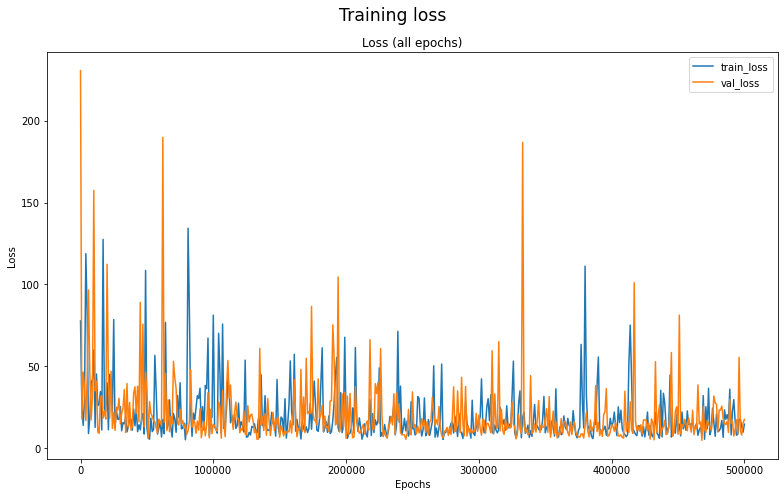

using:  <function compute_mse_loss at 0x146df2040>
14:10:11 STEP: 0; Train loss: 97.720; Validation loss: 177.516; 
14:10:12 STEP: 1000; Train loss: 35.595; Validation loss: 18.064; 
14:10:13 STEP: 2000; Train loss: 20.375; Validation loss: 92.339; 
14:10:14 STEP: 3000; Train loss: 36.122; Validation loss: 28.767; 
14:10:15 STEP: 4000; Train loss: 223.656; Validation loss: 57.781; 
14:10:15 STEP: 5000; Train loss: 49.353; Validation loss: 20.642; 
14:10:16 STEP: 6000; Train loss: 31.121; Validation loss: 172.877; 
14:10:17 STEP: 7000; Train loss: 26.683; Validation loss: 74.736; 
14:10:17 STEP: 8000; Train loss: 34.308; Validation loss: 62.159; 
14:10:18 STEP: 9000; Train loss: 25.034; Validation loss: 49.332; 
14:10:19 STEP: 10000; Train loss: 17.709; Validation loss: 25.544; 
14:10:19 STEP: 11000; Train loss: 14.028; Validation loss: 21.037; 
14:10:20 STEP: 12000; Train loss: 16.859; Validation loss: 18.420; 
14:10:21 STEP: 13000; Train loss: 15.573; Validation loss: 16.827; 
14:10:2

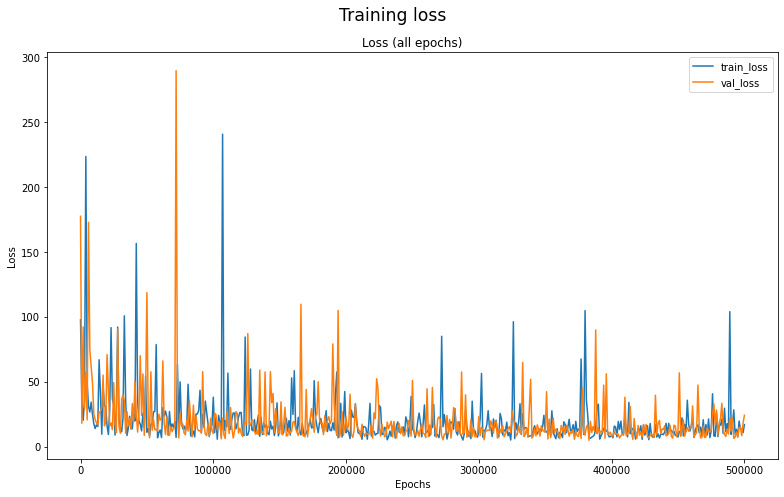

using:  <function compute_mse_loss at 0x146df2040>
14:15:56 STEP: 0; Train loss: 106.287; Validation loss: 187.968; 
14:15:56 STEP: 1000; Train loss: 72.654; Validation loss: 53.389; 
14:15:57 STEP: 2000; Train loss: 40.743; Validation loss: 64.395; 
14:15:58 STEP: 3000; Train loss: 46.693; Validation loss: 58.989; 
14:15:59 STEP: 4000; Train loss: 254.806; Validation loss: 15.891; 
14:15:59 STEP: 5000; Train loss: 189.656; Validation loss: 115.336; 
14:16:00 STEP: 6000; Train loss: 8.845; Validation loss: 174.606; 
14:16:01 STEP: 7000; Train loss: 40.507; Validation loss: 59.489; 
14:16:02 STEP: 8000; Train loss: 69.597; Validation loss: 58.852; 
14:16:02 STEP: 9000; Train loss: 11.494; Validation loss: 27.285; 
14:16:03 STEP: 10000; Train loss: 37.489; Validation loss: 160.182; 
14:16:04 STEP: 11000; Train loss: 41.218; Validation loss: 9.064; 
14:16:05 STEP: 12000; Train loss: 18.899; Validation loss: 14.498; 
14:16:05 STEP: 13000; Train loss: 15.834; Validation loss: 46.423; 
14:16

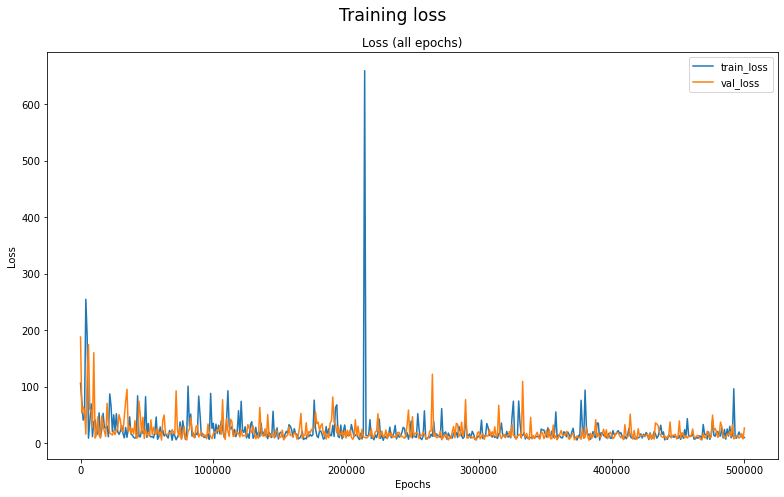

using:  <function compute_mse_loss at 0x146df2040>
14:22:26 STEP: 0; Train loss: 100.901; Validation loss: 166.497; 
14:22:27 STEP: 1000; Train loss: 53.348; Validation loss: 15.450; 
14:22:28 STEP: 2000; Train loss: 22.964; Validation loss: 56.521; 
14:22:29 STEP: 3000; Train loss: 44.572; Validation loss: 31.442; 
14:22:31 STEP: 4000; Train loss: 182.923; Validation loss: 17.075; 
14:22:32 STEP: 5000; Train loss: 11.813; Validation loss: 73.818; 
14:22:33 STEP: 6000; Train loss: 8.687; Validation loss: 245.913; 
14:22:34 STEP: 7000; Train loss: 50.718; Validation loss: 75.573; 
14:22:36 STEP: 8000; Train loss: 84.360; Validation loss: 47.074; 
14:22:37 STEP: 9000; Train loss: 16.669; Validation loss: 26.727; 
14:22:38 STEP: 10000; Train loss: 22.311; Validation loss: 154.744; 
14:22:39 STEP: 11000; Train loss: 84.888; Validation loss: 35.222; 
14:22:40 STEP: 12000; Train loss: 11.995; Validation loss: 26.958; 
14:22:41 STEP: 13000; Train loss: 29.358; Validation loss: 64.945; 
14:22:

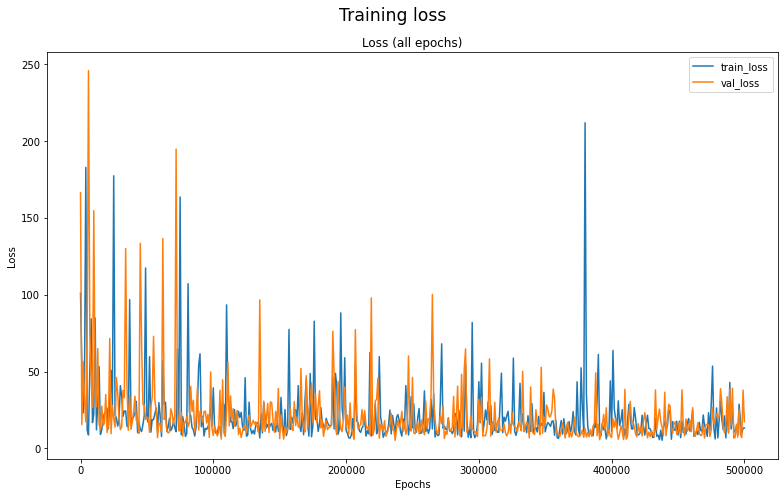

In [12]:
from model_GCN_layers_2 import (
    VGAE_1, VGAE_2, VGAE_3, VGAE_4, VGAE_5, VGAE_8,
    decoder_1, decoder_2, decoder_3, decoder_4, decoder_5, decoder_8,
)

RNG_KEY, training_rng = jax.random.split(RNG_KEY)

all_params = []
vgae_net_fns = [VGAE_1, VGAE_2, VGAE_3, VGAE_4, VGAE_5, VGAE_8]
decoder_net_fns = [decoder_1, decoder_2, decoder_3, decoder_4, decoder_5, decoder_8]
all_num_layers = [1, 2, 3, 4, 5, 8]

for idx, net_fn in enumerate(vgae_net_fns):
    loop_rng = jax.random.fold_in(training_rng, idx)
    # Initialize network and optimizer.
    net = hk.transform(
    lambda x: net_fn(hidden_gnn_dim=ARGS.hidden_gnn_dim,
                    hidden_fc_dim=ARGS.hidden_fc_dim,
                    latent_dim=ARGS.latent_dim, 
                    output_dim=ARGS.output_dim,
                    num_nodes=GP1D_ARGS.num_locations)(x))
    
    params = training_loop(loop_rng, net, optimizer, ARGS.epochs)
    all_params.append(params)

In [13]:
import re
from functools import partial

all_decoder_nets = []
all_decoder_params = []

for decoder_net_fn, params in zip(decoder_net_fns, all_params):
    decoder_params_keys = [k for k in list(params.keys()) if bool(re.search(r'/decoder\w+', k))]
    decoder_params = {}
    for full_key_name in decoder_params_keys:
        key_name = full_key_name.split('/')[-1]  # remove the 'vgae/' prefix
        decoder_params[key_name] = params[full_key_name]
        
    all_decoder_params.append(decoder_params)

    decoder_net_fn = partial(decoder_net_fn,
                            hidden_fc_dim=ARGS.hidden_fc_dim,
                            hidden_gnn_dim=ARGS.hidden_gnn_dim,
                            output_dim=ARGS.output_dim,
                            num_nodes=GP1D_ARGS.num_locations)
    decoder_net = hk.without_apply_rng(hk.transform(decoder_net_fn))
    all_decoder_nets.append(decoder_net)

In [14]:
def decoder_predictive_model(decoder_net, decoder_params):
    z = numpyro.sample('z', dist.Normal(0, 1).expand([ARGS.latent_dim]))
    vgae_out = jnp.squeeze(decoder_net.apply(decoder_params, z).nodes)
    numpyro.deterministic('f', vgae_out)

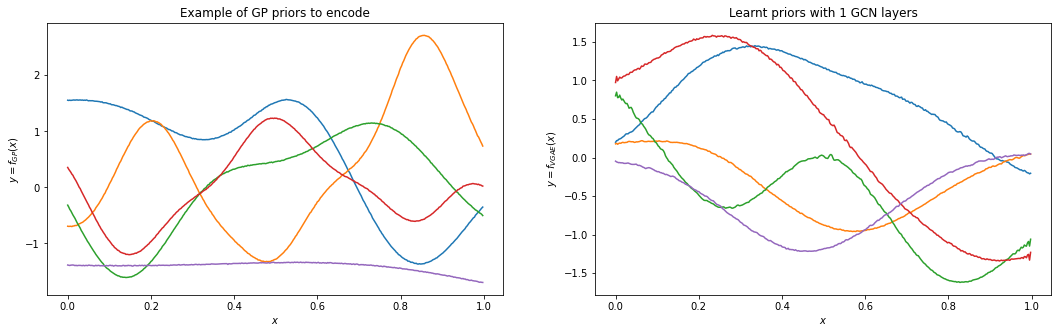

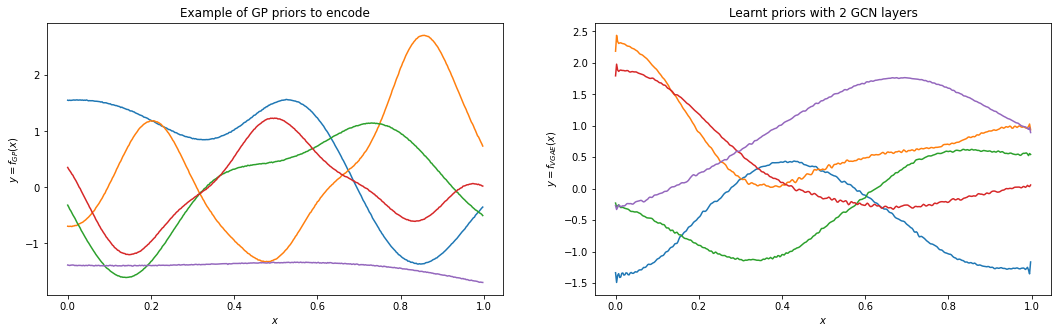

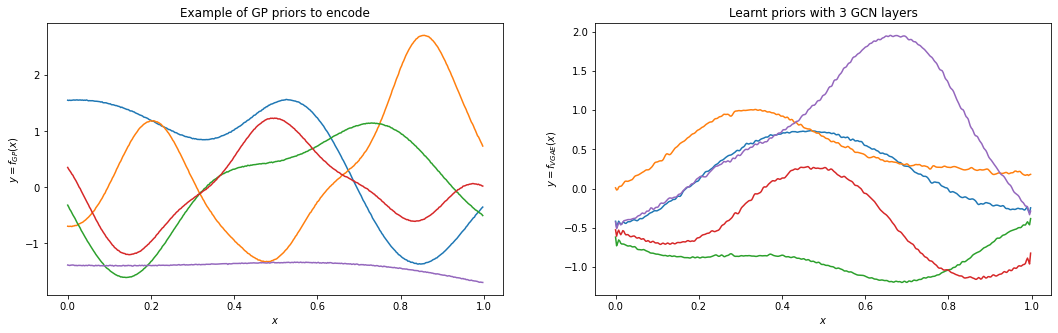

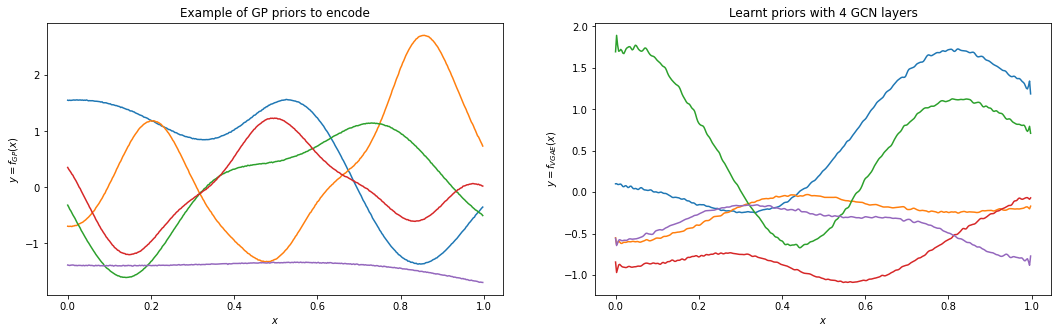

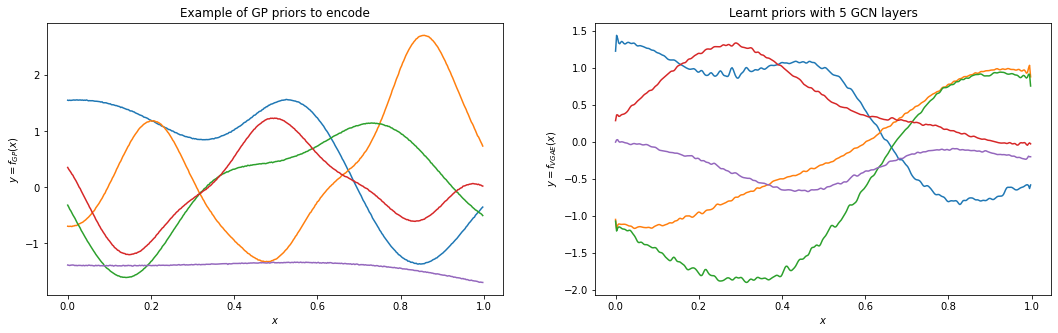

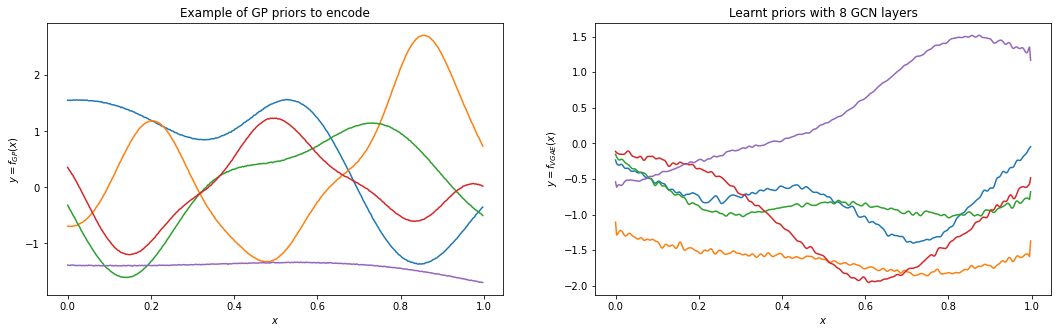

In [15]:
# Rough comparison of the shape of GP draws with learnt VGAE priors.

for num_layers, decoder_net, decoder_params in zip(all_num_layers, all_decoder_nets, all_decoder_params):
  # Drawing VGAE priors.
  RNG_KEY, vgae_sample_rng = jax.random.split(RNG_KEY)
  vgae_draws = Predictive(
    decoder_predictive_model, num_samples=10)(vgae_sample_rng, decoder_net, decoder_params)['f']

  # Plotting the GP draws and VGAE draws.
  _, ax = plt.subplots(1, 2, figsize=(18, 5))

  plotting.plot_gp_draws(X, gp_draws, num_draws_to_plot=5, 
                      ax=ax[0], title='Example of GP priors to encode', y_label='$y=f_{GP}(x)$')

  plotting.plot_gp_draws(X, vgae_draws, num_draws_to_plot=5, 
                      ax=ax[1], title=f'Learnt priors with {num_layers} GCN layers', y_label='$y=f_{VGAE}(x)$', )

  plt.show()

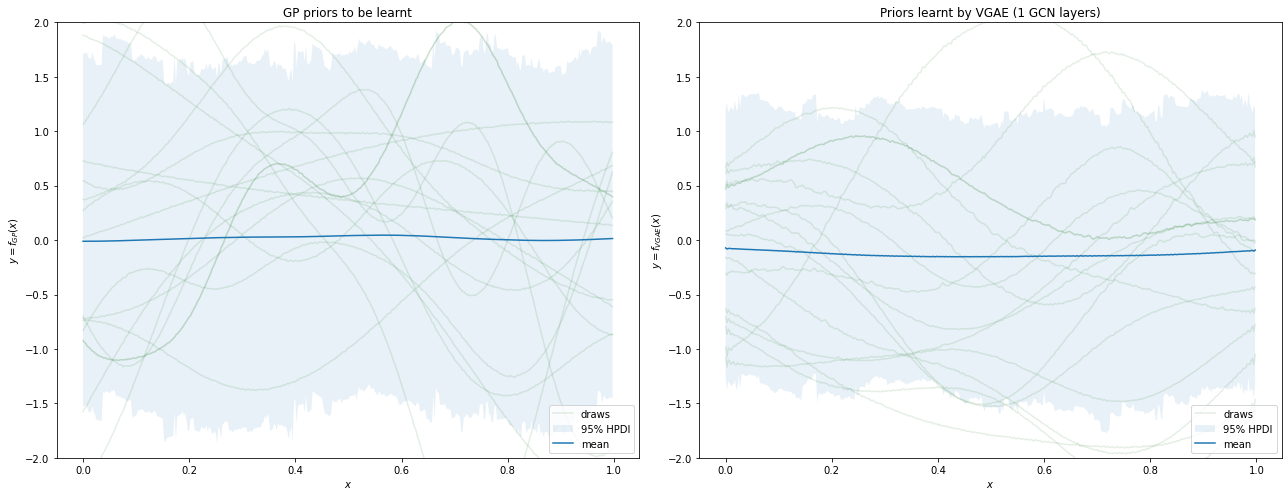

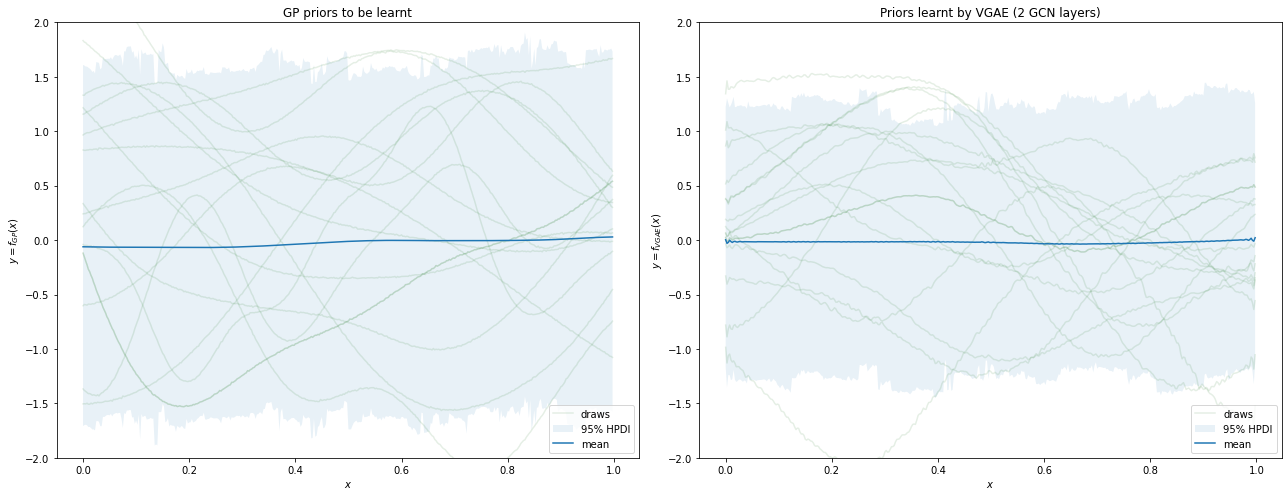

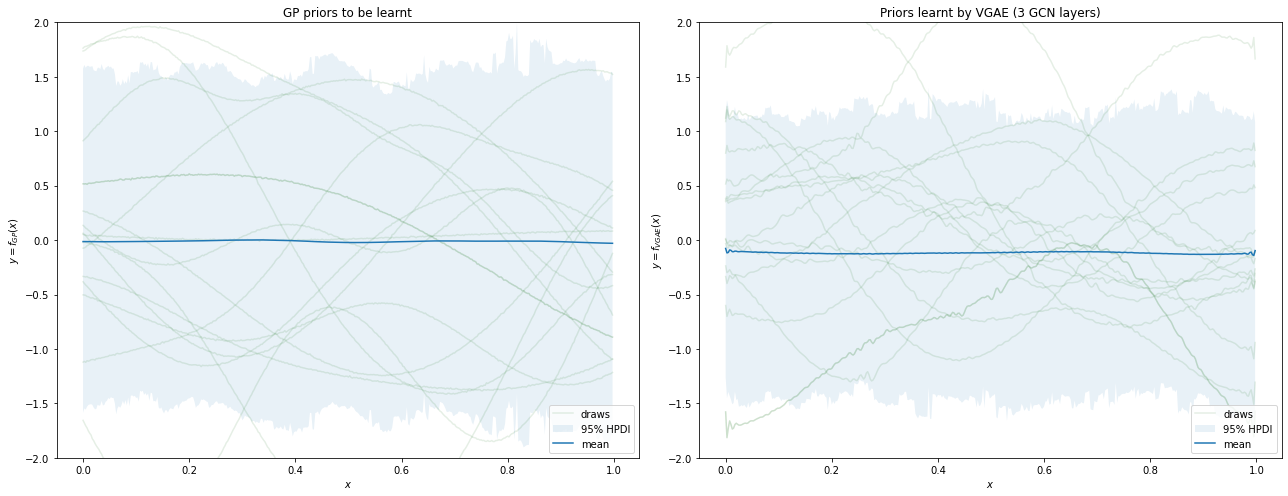

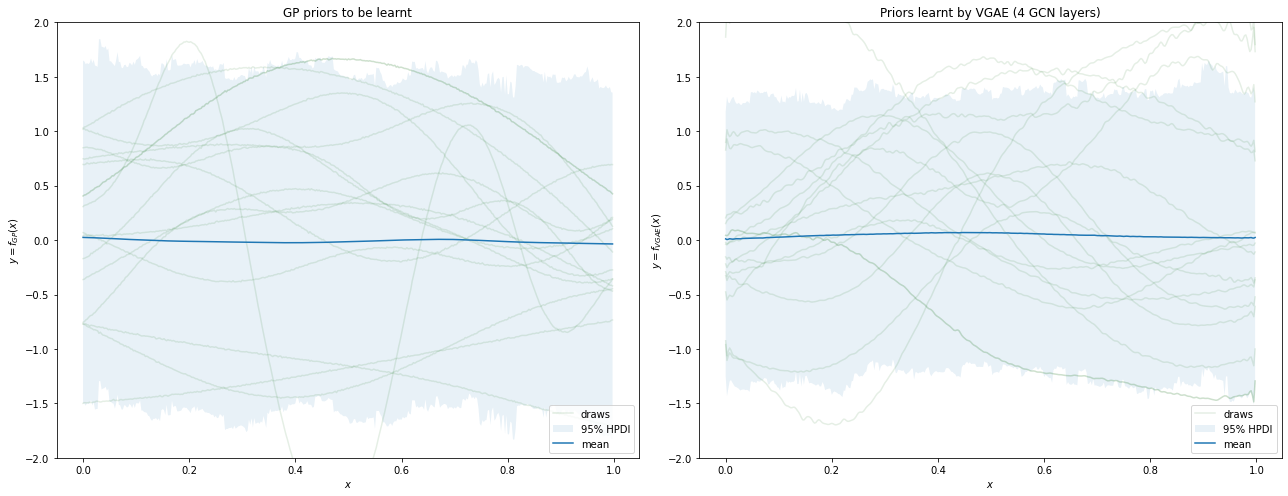

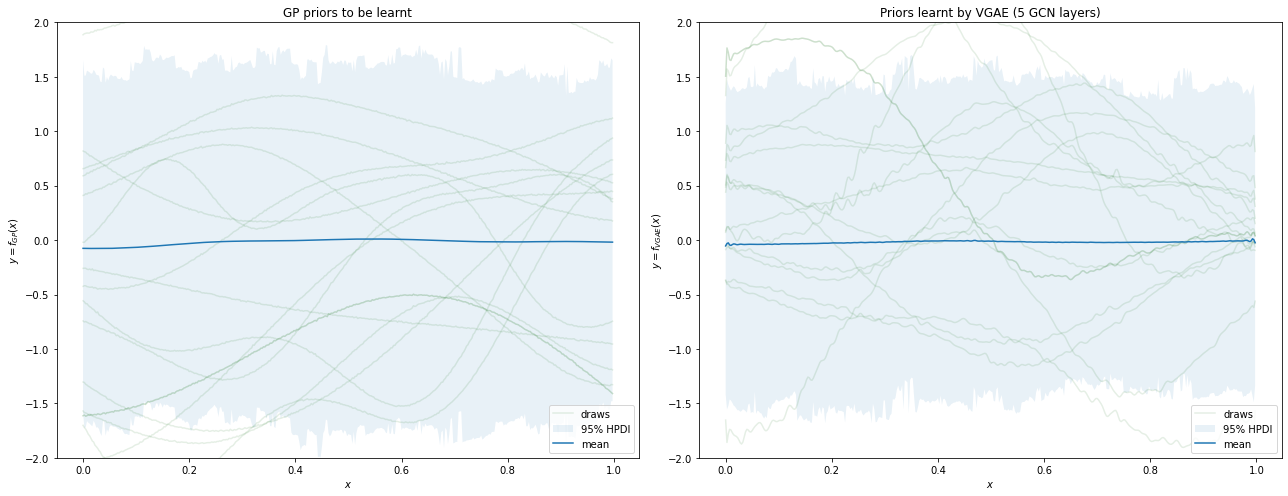

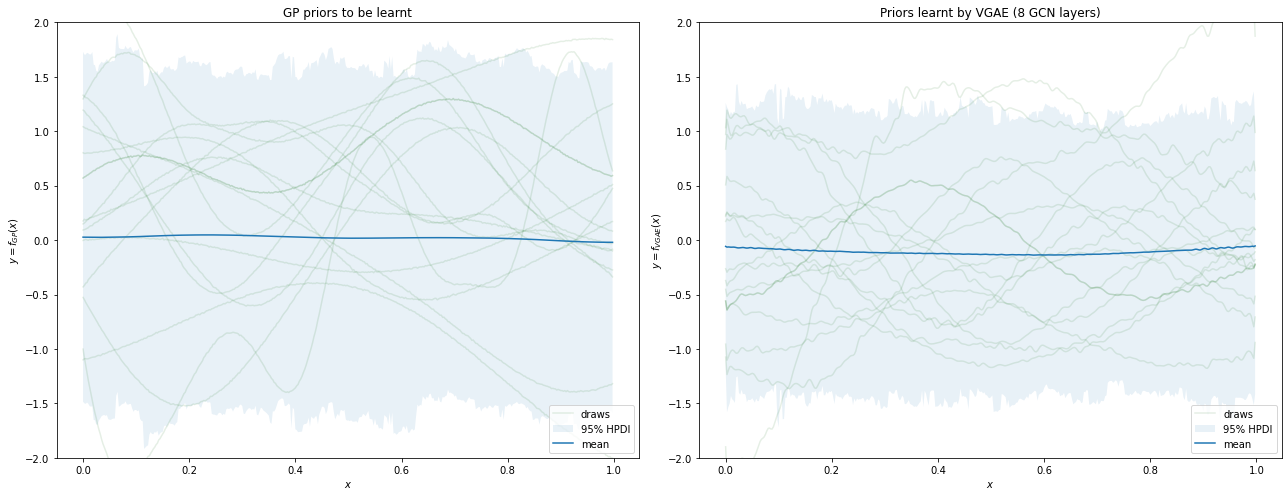

In [16]:
for num_layers, decoder_net, decoder_params in zip(all_num_layers, all_decoder_nets, all_decoder_params):
    # Comparing distribution of GP draws with learnt VGAE priors.
    RNG_KEY, gp_rng, vgae_rng = jax.random.split(RNG_KEY, 3)

    num_samples = 1000
    gp_draws = dataset_1dgp.generate_gp_batch(gp_rng, X, 
                                            batch_size=num_samples, 
                                            kernel=GP1D_ARGS.kernel)
    vgae_draws = Predictive(decoder_predictive_model, num_samples=num_samples
                            )(vgae_rng, decoder_net, decoder_params)['f']

    # Computing the mean and HPDI of the GP draws and VGAE draws.
    gp_draws = gp_draws[~np.isnan(gp_draws).any(axis=1), :]
    mean_gp = jnp.nanmean(gp_draws, axis=0)
    hpdi_gp = hpdi(gp_draws, 0.9)

    vgae_draws = vgae_draws[~np.isnan(vgae_draws).any(axis=1), :]
    mean_vgae = jnp.nanmean(vgae_draws, axis=0)
    hpdi_vgae = hpdi(vgae_draws, 0.9)

    # Plotting the GP draws and VGAE draws.
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    y_lim = [-2, 2]
    lines_alpha_gp = 0.1
    lines_alpha_vgae = 0.1
    num_draws_to_plot = 15
    plotting.plot_gp_draws_with_stats(
        X, gp_draws, 
        mean_gp, hpdi_gp,lines_alpha_gp, 
        num_draws_to_plot, y_lim=y_lim, ax=axes[0],
        title='GP priors to be learnt', y_label='$y=f_{GP}(x)$')
    plotting.plot_gp_draws_with_stats(
        X, vgae_draws, mean_vgae, hpdi_vgae,
        lines_alpha_vgae, num_draws_to_plot, 
        y_lim=y_lim, ax=axes[1],
        title=f'Priors learnt by VGAE ({num_layers} GCN layers)',
        y_label=r'$y=f_{VGAE}(x)$')

    # fig.suptitle(f'GP Priors vs Learnt VGAE Priors \n{model_params_title}', fontsize='xx-large')
    # fig.suptitle(f'GP Priors vs Learnt VGAE Priors', fontsize='xx-large')

    plt.tight_layout()
    plt.show()

In [17]:
assert False, 'Inference is turned off'

AssertionError: Inference is turned off

# Inference on Observed Data

In [ ]:
def vgae_mcmc_predictive_model(y=None, obs_idx=None):
    z = numpyro.sample('z', dist.Normal(0, 1).expand([ARGS.latent_dim]))
    vgae_out = jnp.squeeze(decoder_net.apply(GP1D_ARGS.decoder_params, z).nodes)
    f = numpyro.deterministic('f', vgae_out)
    sigma = numpyro.sample('noise', dist.HalfNormal(0.1))

    if y is None: # at prediction time
        numpyro.sample('y_pred', dist.Normal(f, sigma))
    else: # at inference time
        numpyro.sample('y', dist.Normal(f[obs_idx], sigma), obs=y)

In [ ]:
def run_mcmc(rng, model_mcmc, y, obs_idx, verbose=False):
    start = time.time()
    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(model_mcmc, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=1000,
        num_samples=1000,
        num_chains=4,
        thinning=1,
        progress_bar=False if 'NUMPYRO_SPHINXBUILD' in os.environ else True,
    )
    mcmc.run(rng, y, obs_idx)
    if verbose:
        mcmc.print_summary(exclude_deterministic=False)
    print('\nMCMC elapsed time:', time.time() - start)

    return mcmc.get_samples()

## Ground truth and observed data

In [ ]:
RNG_KEY, gp_rng = jax.random.split(jax.random.PRNGKey(10))
# RNG_KEY, gp_rng = jax.random.split(jax.random.PRNGKey(8))
# RNG_KEY, gp_rng = jax.random.split(jax.random.PRNGKey(6))
# RNG_KEY, gp_rng = jax.random.split(RNG_KEY)

# Generate true data and observed dataset to infer
draws = Predictive(dataset_1dgp.gp_predictive_model, num_samples=1)(
  gp_rng, x=X, gp_kernel=GP1D_ARGS.kernel, noise=True)
gp_draw = draws['f'].T  # True data
y_draw = draws['y'].T  # True data + noise

assert not jnp.isnan(y_draw).any(), 'NaNs in y_draw'

# Choose indices of datapoints for inference.
obs_locations = [
  jnp.array([122, 321]),  # 2 observed datapoints
  jnp.array([126, 133, 296, 370]),  # 4 observed datapoints
  jnp.array([71, 85, 111, 291, 314, 380]),  # 6 observed datapoints
  # jnp.array([71, 85, 88, 111, 291, 300, 314, 380]),  # 8 observed datapoints
]

In [ ]:
mean_post_preds_list = []
hpdi_post_preds_list = []
obs_xs = []
obs_ys = []
predictions_list = []

RNG_KEY, inference_rng = jax.random.split(RNG_KEY)

for i, obs_location in enumerate(obs_locations):
    mcmc_rng, pred_rng = jax.random.split(jax.random.fold_in(inference_rng, i))
    
    x_obs = X[obs_location]
    y_obs = jnp.squeeze(y_draw[obs_location])
    
    print(f'Running chain for n_obs = {len(obs_location)}')
    mcmc_samples = run_mcmc(mcmc_rng, vgae_mcmc_predictive_model, y_obs, obs_location)

    predictions = Predictive(vgae_mcmc_predictive_model, mcmc_samples)(pred_rng)['f']
    mean_post_pred = jnp.mean(predictions, axis=0)
    hpdi_post_pred = hpdi(predictions, 0.9)
    
    obs_xs.append(x_obs)
    obs_ys.append(y_obs)
    predictions_list.append(predictions)
    mean_post_preds_list.append(mean_post_pred)
    hpdi_post_preds_list.append(hpdi_post_pred)

Running chain for n_obs = 2


/var/folders/6h/lf5jg1fn1h163zw3042tmtnc0000gn/T/ipykernel_19927/3494085863.py:5: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 2000/2000 [00:15<00:00, 127.33it/s, 63 steps of size 7.86e-02. acc. prob=0.84]



MCMC elapsed time: 56.847652196884155
Running chain for n_obs = 4


/var/folders/6h/lf5jg1fn1h163zw3042tmtnc0000gn/T/ipykernel_19927/3494085863.py:5: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 2000/2000 [00:26<00:00, 75.83it/s, 127 steps of size 2.75e-02. acc. prob=0.95]



MCMC elapsed time: 91.6055600643158
Running chain for n_obs = 6


/var/folders/6h/lf5jg1fn1h163zw3042tmtnc0000gn/T/ipykernel_19927/3494085863.py:5: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 2000/2000 [00:12<00:00, 160.29it/s, 5 steps of size 9.06e-02. acc. prob=0.79] 



MCMC elapsed time: 55.151432037353516


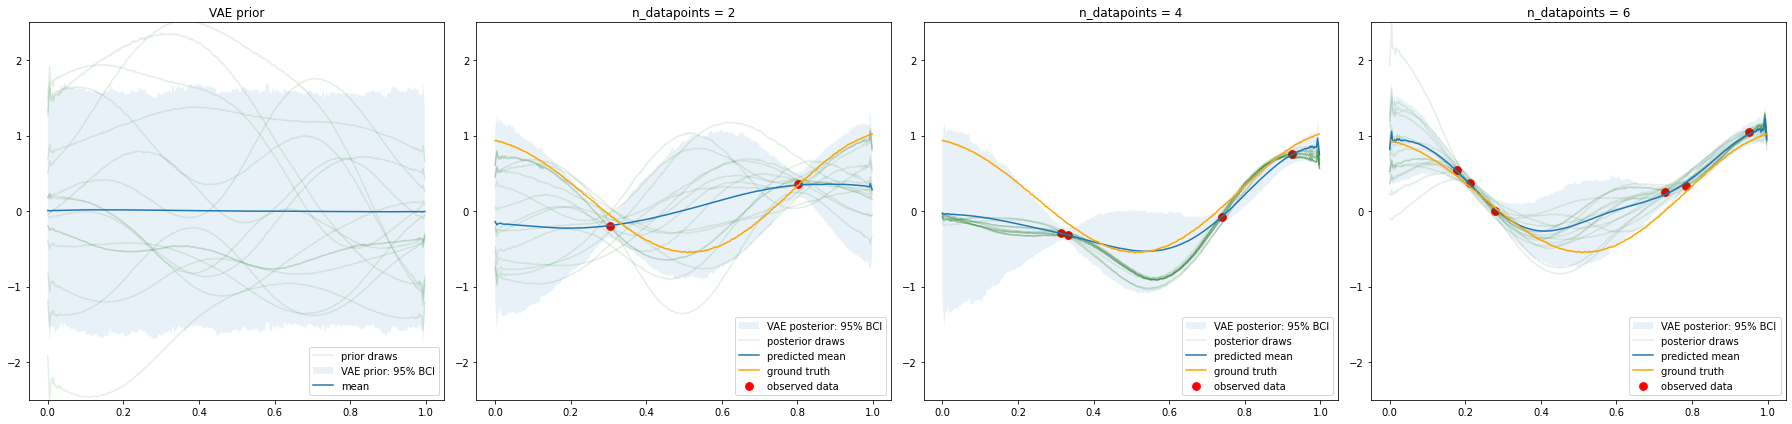

In [ ]:
# Plotting results after inference using MCMC.
_, axes = plt.subplots(nrows=1, ncols=len(obs_locations)+1, figsize=(25,6))

# Plotting VAE prior predictive.
RNG_KEY, prior_rng = jax.random.split(RNG_KEY)
prior_predictions = Predictive(vgae_mcmc_predictive_model, num_samples=10000)(prior_rng)['f']
mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)

num_draws_to_plot = 15
for j in range(num_draws_to_plot):
    axes[0].plot(X, prior_predictions[j], alpha=0.1, color='darkgreen')
axes[0].plot(X, prior_predictions[0], 
             alpha=0.1, color='darkgreen', label='prior draws')  
axes[0].fill_between(X, hpdi_prior_pred[0], hpdi_prior_pred[1], 
                     alpha=0.1, interpolate=True, label='VAE prior: 95% BCI')
axes[0].plot(X, mean_prior_pred, label='mean')
axes[0].set_title('VAE prior')


# Plotting VAE posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    axes[idx+1].fill_between(X, hpdi_post_preds_list[idx][0], hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VAE posterior: 95% BCI')
    for j in range(num_draws_to_plot): 
        axes[idx+1].plot(X, predictions_list[idx][j], alpha=0.1, color='darkgreen')
    axes[idx+1].plot(X, predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws')  
    axes[idx+1].plot(X, mean_post_preds_list[idx], label='predicted mean')
    axes[idx+1].plot(X, gp_draw, label='ground truth', color='orange')
    axes[idx+1].scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=60)
    axes[idx+1].set_title('n_datapoints = ' + str(len(obs_locations[idx])))


for i in range(len(obs_locations)+1):    
    axes[i].legend(loc=4)
    axes[i].set_ylim([-2.5, 2.5])

plt.tight_layout()
plt.show()

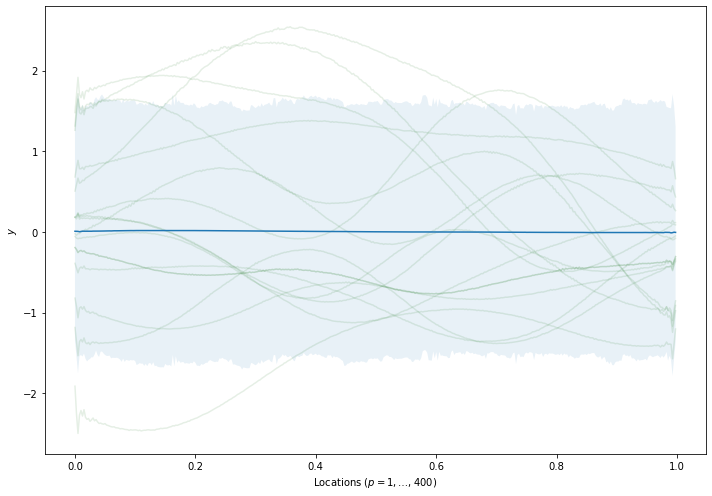

In [ ]:
# Plotting results after inference using MCMC.
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

num_draws_to_plot = 15
for j in range(num_draws_to_plot):
    ax.plot(X, prior_predictions[j], alpha=0.1, color='darkgreen')
ax.plot(X, prior_predictions[0], 
             alpha=0.1, color='darkgreen', label='prior draws')  
ax.fill_between(X, hpdi_prior_pred[0], hpdi_prior_pred[1], 
                     alpha=0.1, interpolate=True, label='VAE prior: 95% BCI')
ax.plot(X, mean_prior_pred, label='mean')
# ax.set_title('VAE prior')

ax.set_xlabel('Locations ($p=1, \ldots, 400$)')
ax.set_ylabel(r'$y$')

plt.tight_layout()
plt.show();

save_to_dir = FIG_PATH / 'publication'
fig.savefig(save_to_dir / '1DGP_inference_1.jpg', dpi=300)

n_datapoints = 2


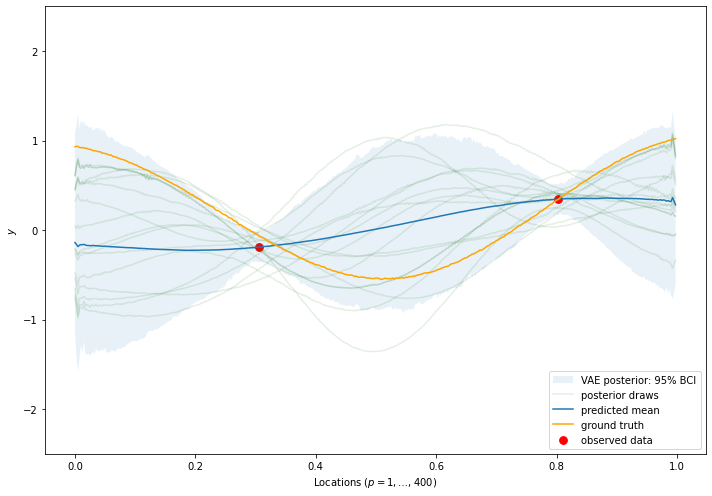

n_datapoints = 4


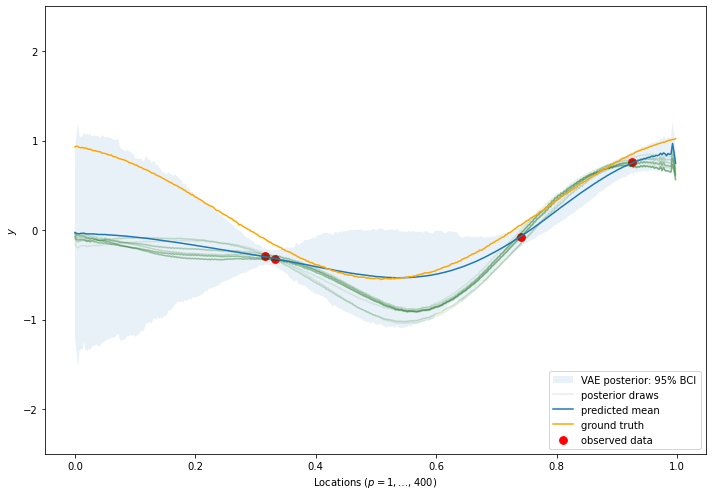

n_datapoints = 6


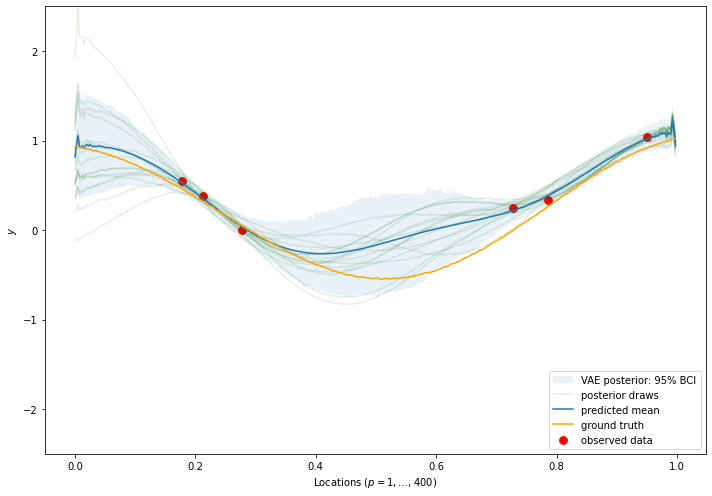

In [ ]:
# Plotting VAE posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    print(f'n_datapoints = {len(obs_locations[idx])}')
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    
    ax.fill_between(X, hpdi_post_preds_list[idx][0], hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VAE posterior: 95% BCI')
    for j in range(num_draws_to_plot): 
        ax.plot(X, predictions_list[idx][j], alpha=0.1, color='darkgreen')
    ax.plot(X, predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws')  
    ax.plot(X, mean_post_preds_list[idx], label='predicted mean')
    ax.plot(X, gp_draw, label='ground truth', color='orange')
    ax.scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=60)
    # ax.set_title('n_datapoints = ' + str(len(obs_locations[idx])))
    
    ax.legend(loc=4)
    ax.set_ylim([-2.5, 2.5])
    
    ax.set_xlabel('Locations ($p=1, \ldots, 400$)')
    ax.set_ylabel(r'$y$')
    
    plt.tight_layout()
    plt.show()
    
    save_to_dir = FIG_PATH / 'publication'
    fig.savefig(save_to_dir / f'1DGP_inference_{idx+2}.jpg', dpi=300)

Text(0.5, 1.0, 'VGAE covariance matrix')

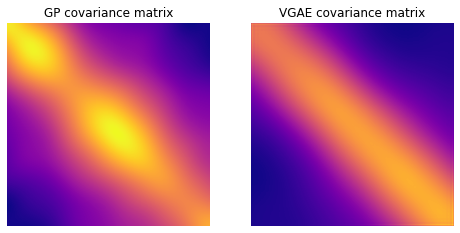

In [ ]:
# RNG_KEY, gp_rng, vgae_rng = jax.random.split(jax.random.PRNGKey(44), 3)
RNG_KEY, gp_rng, vgae_rng = jax.random.split(jax.random.PRNGKey(6), 3)
# RNG_KEY, gp_rng, vgae_rng = jax.random.split(jax.random.PRNGKey(16), 3)

gp_predictive = Predictive(dataset_1dgp.gp_predictive_model, num_samples=100)
gp_draws = gp_predictive(gp_rng, x=X, gp_kernel=GP1D_ARGS.kernel, kernel_jitter=1e-5)['y']
gp_draws = dataset_1dgp.remove_nans_from_gp(gp_draws)

vgae_predictive = Predictive(vgae_mcmc_predictive_model, num_samples=100)
vgae_draws = vgae_predictive(vgae_rng)['f']
vgae_draws = dataset_1dgp.remove_nans_from_gp(vgae_draws)

m_vgae = np.cov(np.transpose(vgae_draws))
m_gp = np.cov(np.transpose(gp_draws))

cmap_choice = 'plasma'

#'plasma'
#'inferno'
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (8,4))
axs[0].imshow(m_gp, cmap=cmap_choice)
axs[0].axis('off')
axs[0].set_title('GP covariance matrix')

axs[1].imshow(m_vgae, cmap=cmap_choice)
axs[1].axis('off')
axs[1].set_title('VGAE covariance matrix')

## Priors learnt by VAE

In [ ]:
vae_model_name = '1DGP_PriorVAE_0.01lr_5000epochs_50h1Dim_50h2Dim_30latentDim_400numLocations_100batchSize'
model_path = Path('./models/') / vae_model_name

print(f"Loading VAE model from {model_path}")
vae_params = model.restore_params(model_path)

Loading VAE model from models/1DGP_PriorVAE_0.01lr_5000epochs_50h1Dim_50h2Dim_30latentDim_400numLocations_100batchSize


In [ ]:
vae_decoder_params_keys = [k for k in list(vae_params.keys()) if k.startswith('variational_auto_encoder/decoder')]
vae_decoder_params = {}
for full_key_name in vae_decoder_params_keys:
    key_name = ('/').join(full_key_name.split('/')[2:])  # remove the 'variational_auto_encoder/' prefix
    vae_decoder_params[key_name] = vae_params[full_key_name]

vae_decoder_net = hk.without_apply_rng(
    hk.transform(  
      lambda z: model.priorvae_decoder(
        z,
        hidden1_dim=50,
        hidden2_dim=50,
        output_dim=GP1D_ARGS.num_locations
    )
))

def vae_decoder_predictive_model():
    z = numpyro.sample('z', dist.Normal(0, 1).expand([30]))
    vae_out = jnp.squeeze(vae_decoder_net.apply(vae_decoder_params, z))
    numpyro.deterministic('f', vae_out)

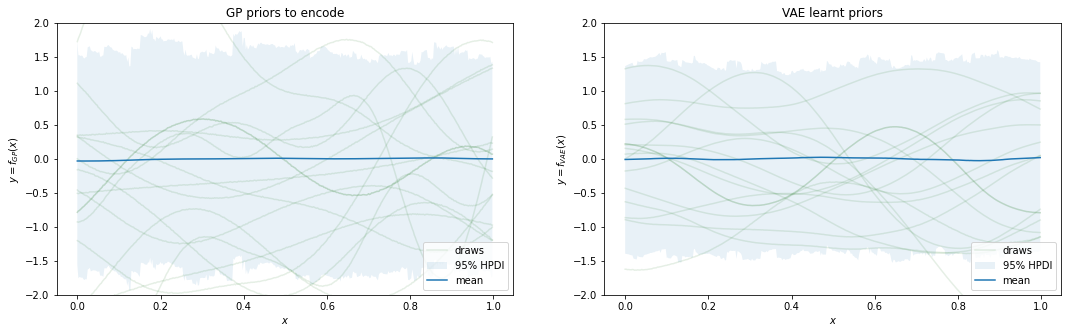

In [ ]:
# Comparing distribution of GP draws with learnt VAE priors.

RNG_KEY, rng_gp, rng_vae = jax.random.split(RNG_KEY, 3)
gp_draws = dataset_1dgp.generate_gp_batch(
    rng_gp, X, batch_size=1000, kernel=GP1D_ARGS.kernel)  # batch_size is equivalent to `num_samples`.
vae_draws = Predictive(vae_decoder_predictive_model, num_samples=1000)(rng_vae)['f']

# Computing the mean and HPDI of the GP draws and VAE draws.
gp_draws = gp_draws[~np.isnan(gp_draws).any(axis=1), :]
mean_gp = jnp.nanmean(gp_draws, axis=0)
hpdi_gp = hpdi(gp_draws, 0.9)

vae_draws = vae_draws[~np.isnan(vae_draws).any(axis=1), :]
mean_vae = jnp.nanmean(vae_draws, axis=0)
hpdi_vae = hpdi(vae_draws, 0.9)

# Plotting the GP draws and VAE draws.
_, axes = plt.subplots(1, 2, figsize=(18, 5))

y_lim = [-2, 2]
lines_alpha_gp = 0.1
lines_alpha_vae = 0.1
num_draws_to_plot = 15
plotting.plot_gp_draws_with_stats(
    X, gp_draws, 
    mean_gp, hpdi_gp,lines_alpha_gp, 
    num_draws_to_plot, y_lim=y_lim, ax=axes[0],
    title='GP priors to encode', y_label='$y=f_{GP}(x)$')
plotting.plot_gp_draws_with_stats(
    X, vae_draws, mean_vae, hpdi_vae,
    lines_alpha_vae, num_draws_to_plot, 
    y_lim=y_lim, ax=axes[1],
    title='VAE learnt priors', y_label='$y=f_{VAE}(x)$')

plt.show()

In [ ]:
def vae_model_mcmc(y=None, obs_idx=None):
    z = numpyro.sample('z', dist.Normal(0, 1).expand([ARGS.latent_dim]))
    vae_out = jnp.squeeze(vae_decoder_net.apply(vae_decoder_params, z))
    f = numpyro.deterministic('f', vae_out)
    sigma = numpyro.sample('noise', dist.HalfNormal(0.1))

    if y is None: # at prediction time
        numpyro.sample('y_pred', dist.Normal(f, sigma))
    else: # at inference time
        numpyro.sample('y', dist.Normal(f[obs_idx], sigma), obs=y)

In [ ]:
vae_mean_post_preds_list = []
vae_hpdi_post_preds_list = []
obs_xs = []
obs_ys = []
vae_predictions_list = []

RNG_KEY, inference_rng = jax.random.split(RNG_KEY)

for i, obs_location in enumerate(obs_locations):
    mcmc_rng, pred_rng = jax.random.split(jax.random.fold_in(inference_rng, i))
    
    x_obs = X[obs_location]
    y_obs = jnp.squeeze(y_draw[obs_location])
    
    print(f'Running chain for n_obs = {len(obs_location)}')
    mcmc_samples = run_mcmc(mcmc_rng, vae_model_mcmc, y_obs, obs_location)

    predictions = Predictive(vae_model_mcmc, mcmc_samples)(pred_rng)['f']
    mean_post_pred = jnp.mean(predictions, axis=0)
    hpdi_post_pred = hpdi(predictions, 0.9)
    
    obs_xs.append(x_obs)
    obs_ys.append(y_obs)
    vae_predictions_list.append(predictions)
    vae_mean_post_preds_list.append(mean_post_pred)
    vae_hpdi_post_preds_list.append(hpdi_post_pred)

Running chain for n_obs = 2


/var/folders/6h/lf5jg1fn1h163zw3042tmtnc0000gn/T/ipykernel_19927/3494085863.py:5: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 2000/2000 [00:00<00:00, 2118.02it/s, 15 steps of size 1.25e-01. acc. prob=0.73]



MCMC elapsed time: 6.037938833236694


/var/folders/6h/lf5jg1fn1h163zw3042tmtnc0000gn/T/ipykernel_19927/3494085863.py:5: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


Running chain for n_obs = 4


sample: 100%|██████████| 2000/2000 [00:00<00:00, 2080.21it/s, 31 steps of size 1.09e-01. acc. prob=0.66]



MCMC elapsed time: 5.718899965286255


/var/folders/6h/lf5jg1fn1h163zw3042tmtnc0000gn/T/ipykernel_19927/3494085863.py:5: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


Running chain for n_obs = 6


sample: 100%|██████████| 2000/2000 [00:00<00:00, 2470.01it/s, 15 steps of size 2.55e-01. acc. prob=0.91]



MCMC elapsed time: 4.73140811920166


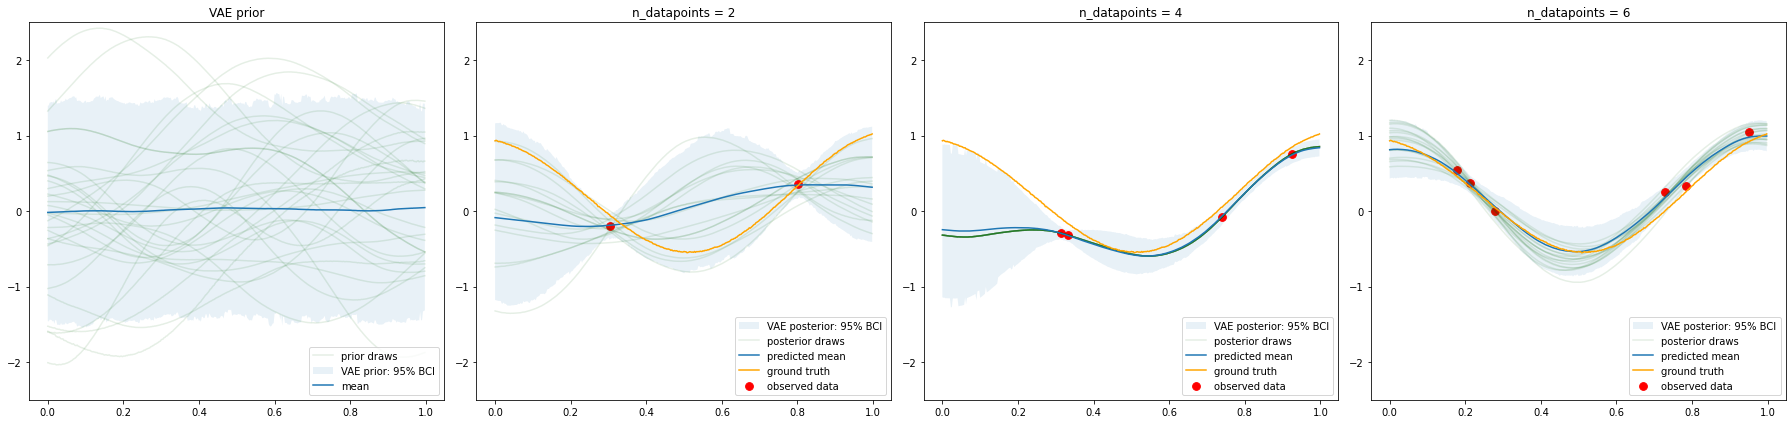

In [ ]:
# Plotting results after inference using MCMC.
_, axes = plt.subplots(nrows=1, ncols=len(obs_locations)+1, figsize=(25,6))

# Plotting VAE prior predictive.
RNG_KEY, prior_rng = jax.random.split(RNG_KEY)
vae_prior_predictions = Predictive(vae_model_mcmc, num_samples=10000)(prior_rng)['f']
vae_mean_prior_pred = jnp.mean(vae_prior_predictions, axis=0)
vae_hpdi_prior_pred = hpdi(vae_prior_predictions, 0.9)

num_draws_to_plot = 30
for j in range(num_draws_to_plot):
    axes[0].plot(X, vae_prior_predictions[j], alpha=0.1, color='darkgreen')
axes[0].plot(X, vae_prior_predictions[0], 
             alpha=0.1, color='darkgreen', label='prior draws')  
axes[0].fill_between(X, vae_hpdi_prior_pred[0], vae_hpdi_prior_pred[1], 
                     alpha=0.1, interpolate=True, label='VAE prior: 95% BCI')
axes[0].plot(X, vae_mean_prior_pred, label='mean')
axes[0].set_title('VAE prior')


# Plotting VAE posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    axes[idx+1].fill_between(X, vae_hpdi_post_preds_list[idx][0], vae_hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VAE posterior: 95% BCI')
    for j in range(num_draws_to_plot): 
        axes[idx+1].plot(X, vae_predictions_list[idx][j], alpha=0.1, color='darkgreen')
    axes[idx+1].plot(X, vae_predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws')  
    axes[idx+1].plot(X, vae_mean_post_preds_list[idx], label='predicted mean')
    axes[idx+1].plot(X, gp_draw, label='ground truth', color='orange')
    axes[idx+1].scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=60)
    axes[idx+1].set_title('n_datapoints = ' + str(len(obs_locations[idx])))


for i in range(len(obs_locations)+1):    
    axes[i].legend(loc=4)
    axes[i].set_ylim([-2.5, 2.5])

plt.tight_layout()
plt.show()

## Both plots

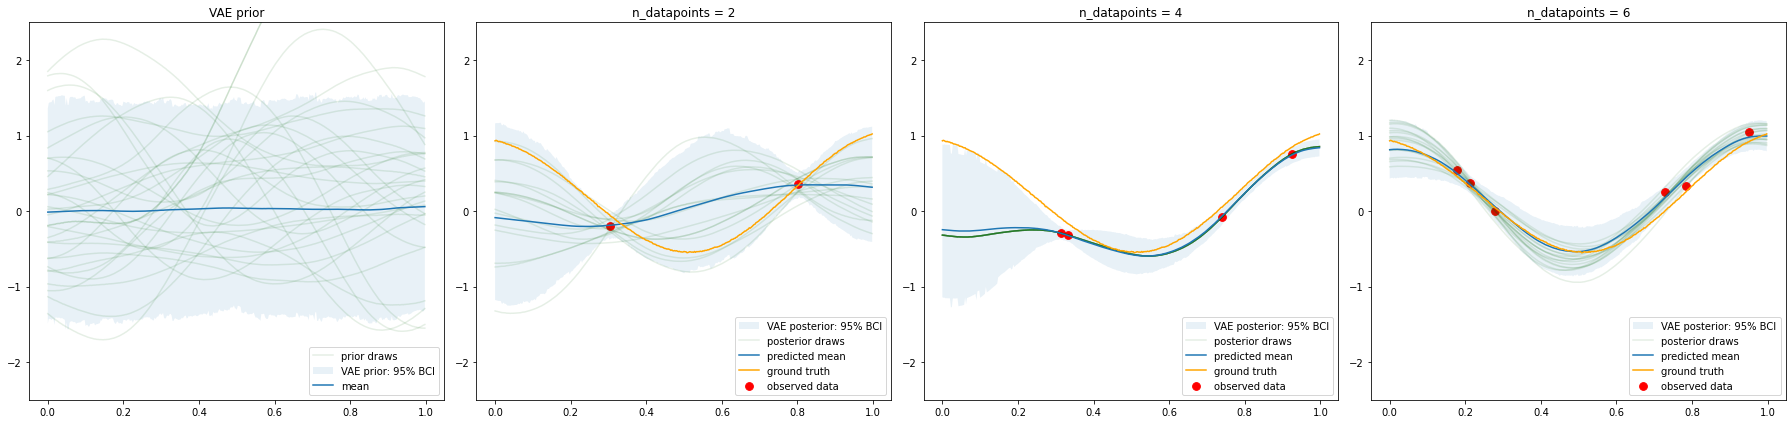

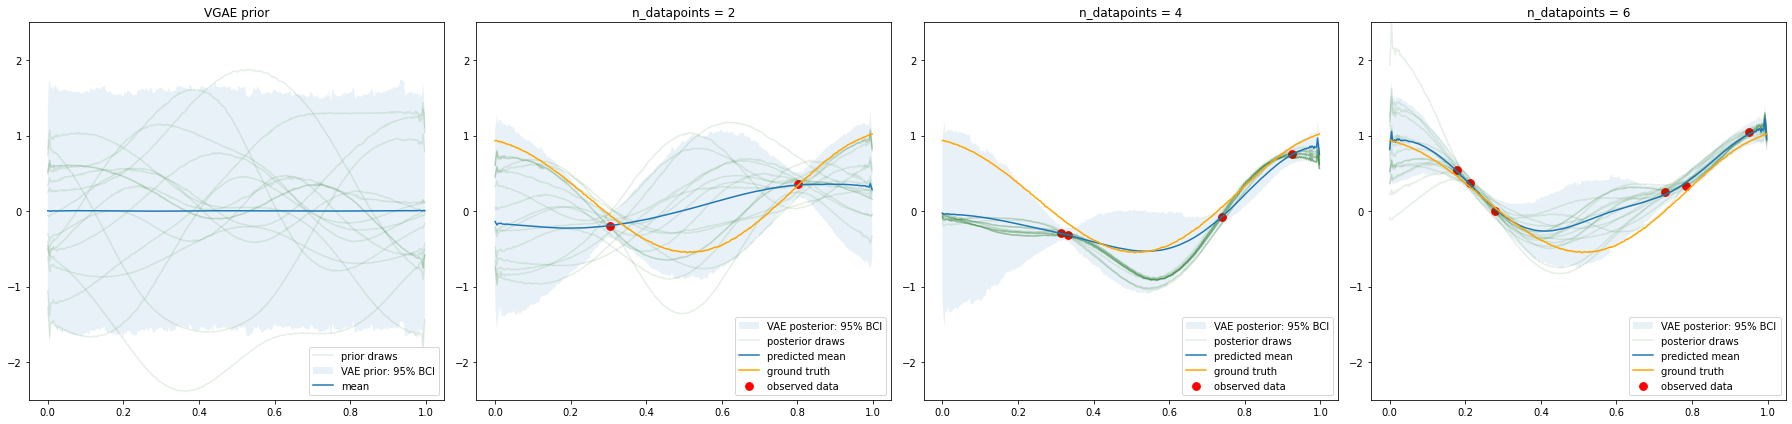

In [ ]:
# Plotting results after inference using MCMC.
_, axes = plt.subplots(nrows=1, ncols=len(obs_locations)+1, figsize=(25,6))

# Plotting VAE prior predictive.
RNG_KEY, prior_rng = jax.random.split(RNG_KEY)
vae_prior_predictions = Predictive(vae_model_mcmc, num_samples=10000)(prior_rng)['f']
vae_mean_prior_pred = jnp.mean(vae_prior_predictions, axis=0)
vae_hpdi_prior_pred = hpdi(vae_prior_predictions, 0.9)

num_draws_to_plot = 30
for j in range(num_draws_to_plot):
    axes[0].plot(X, vae_prior_predictions[j], alpha=0.1, color='darkgreen')
axes[0].plot(X, vae_prior_predictions[0], 
             alpha=0.1, color='darkgreen', label='prior draws')  
axes[0].fill_between(X, vae_hpdi_prior_pred[0], vae_hpdi_prior_pred[1], 
                     alpha=0.1, interpolate=True, label='VAE prior: 95% BCI')
axes[0].plot(X, vae_mean_prior_pred, label='mean')
axes[0].set_title('VAE prior')


# Plotting VAE posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    axes[idx+1].fill_between(X, vae_hpdi_post_preds_list[idx][0], vae_hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VAE posterior: 95% BCI')
    for j in range(num_draws_to_plot): 
        axes[idx+1].plot(X, vae_predictions_list[idx][j], alpha=0.1, color='darkgreen')
    axes[idx+1].plot(X, vae_predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws')  
    axes[idx+1].plot(X, vae_mean_post_preds_list[idx], label='predicted mean')
    axes[idx+1].plot(X, gp_draw, label='ground truth', color='orange')
    axes[idx+1].scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=60)
    axes[idx+1].set_title('n_datapoints = ' + str(len(obs_locations[idx])))


for i in range(len(obs_locations)+1):    
    axes[i].legend(loc=4)
    axes[i].set_ylim([-2.5, 2.5])

plt.tight_layout()
plt.show()

# Plotting results after inference using MCMC.
_, axes = plt.subplots(nrows=1, ncols=len(obs_locations)+1, figsize=(25,6))

# Plotting VAE prior predictive.
RNG_KEY, prior_rng = jax.random.split(RNG_KEY)
prior_predictions = Predictive(vgae_mcmc_predictive_model, num_samples=10000)(prior_rng)['f']
mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)

num_draws_to_plot = 15
for j in range(num_draws_to_plot):
    axes[0].plot(X, prior_predictions[j], alpha=0.1, color='darkgreen')
axes[0].plot(X, prior_predictions[0], 
             alpha=0.1, color='darkgreen', label='prior draws')  
axes[0].fill_between(X, hpdi_prior_pred[0], hpdi_prior_pred[1], 
                     alpha=0.1, interpolate=True, label='VAE prior: 95% BCI')
axes[0].plot(X, mean_prior_pred, label='mean')
axes[0].set_title('VGAE prior')


# Plotting VAE posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    axes[idx+1].fill_between(X, hpdi_post_preds_list[idx][0], hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VAE posterior: 95% BCI')
    for j in range(num_draws_to_plot): 
        axes[idx+1].plot(X, predictions_list[idx][j], alpha=0.1, color='darkgreen')
    axes[idx+1].plot(X, predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws')  
    axes[idx+1].plot(X, mean_post_preds_list[idx], label='predicted mean')
    axes[idx+1].plot(X, gp_draw, label='ground truth', color='orange')
    axes[idx+1].scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=60)
    axes[idx+1].set_title('n_datapoints = ' + str(len(obs_locations[idx])))


for i in range(len(obs_locations)+1):    
    axes[i].legend(loc=4)
    axes[i].set_ylim([-2.5, 2.5])

plt.tight_layout()
plt.show()

In [ ]:
mean_post_pred_vae = vae_mean_post_preds_list[-1]
mean_post_pred_vgae = mean_post_preds_list[-1]

mse_vgae = np.mean((gp_draw.flatten() -  mean_post_pred_vgae)**2)
mse_vae = np.mean((gp_draw.flatten() -  mean_post_pred_vae)**2)
print(f'mse_vgae = {mse_vgae}')
print(f'mse_vae = {mse_vae}')

mse_vgae = 0.04861881211400032
mse_vae = 0.009093127213418484
